In [19]:
# https://github.com/tuongv-1736461/EE399

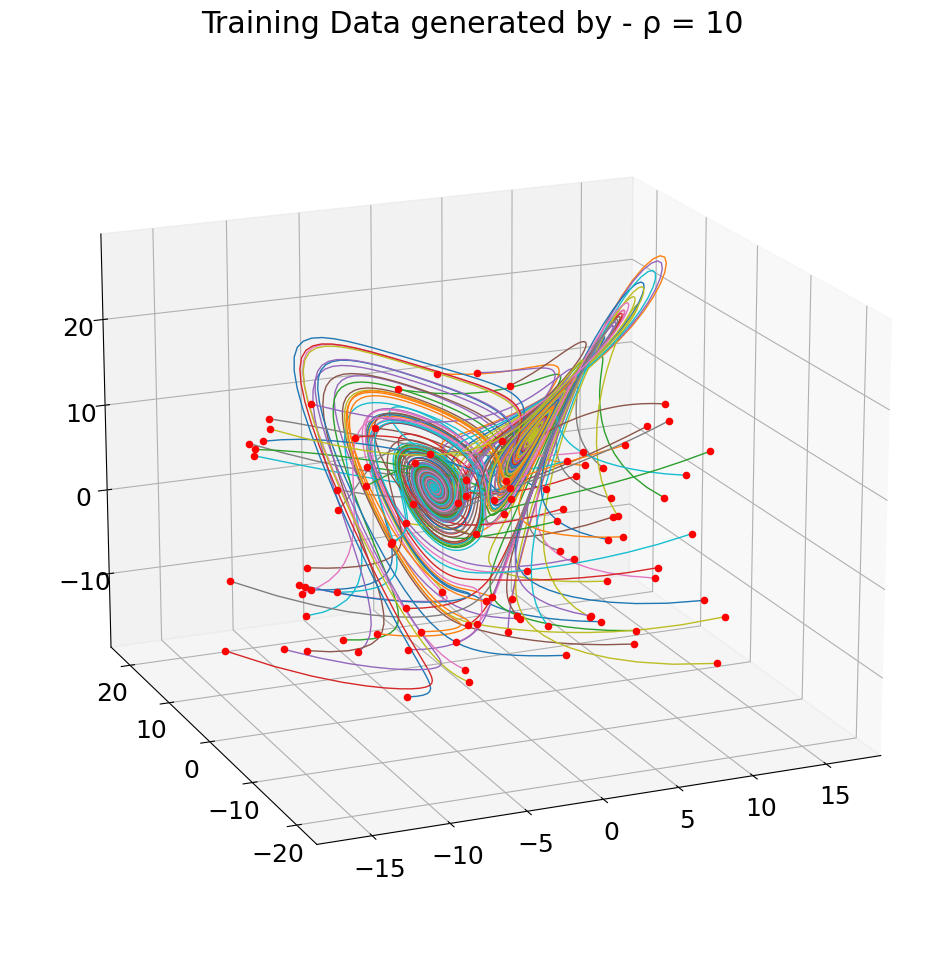

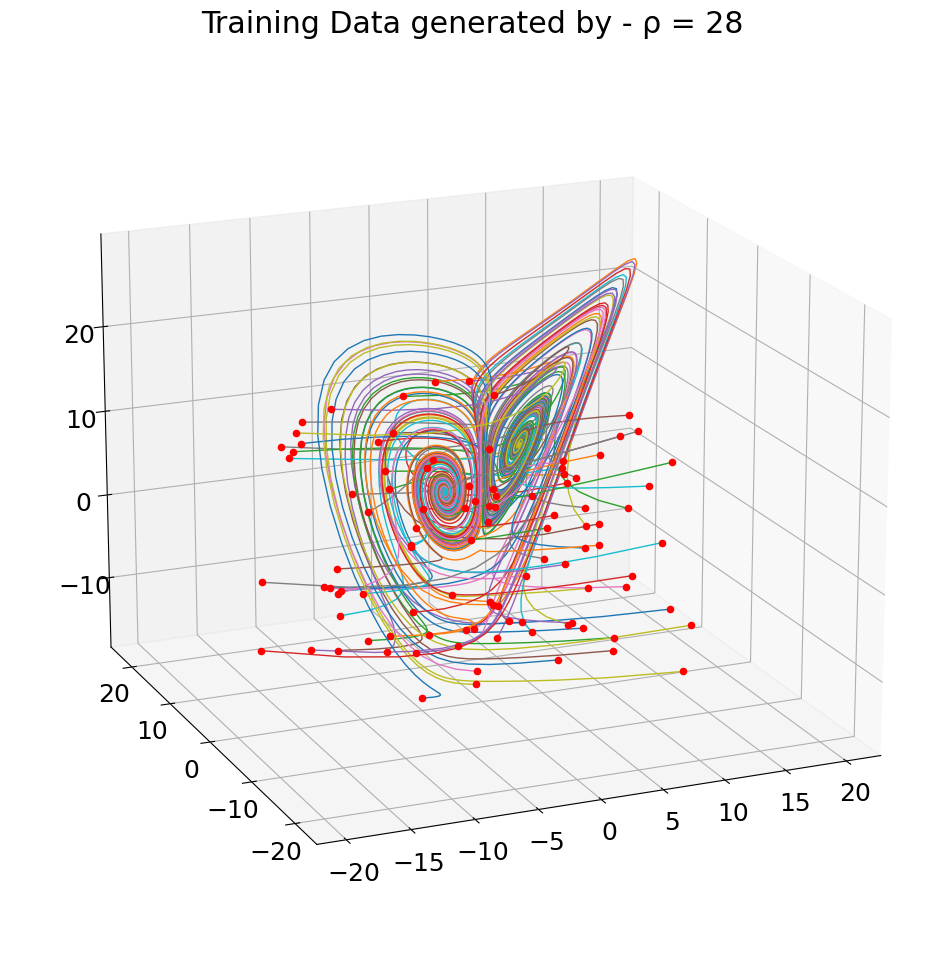

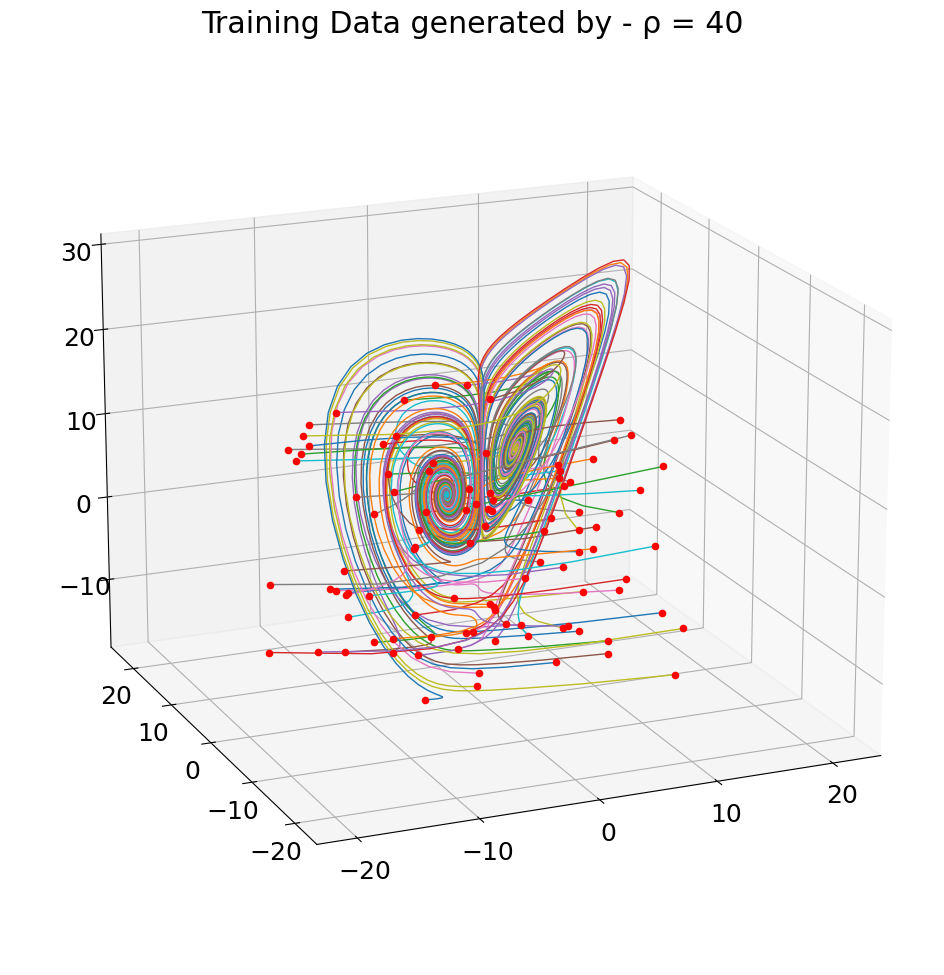

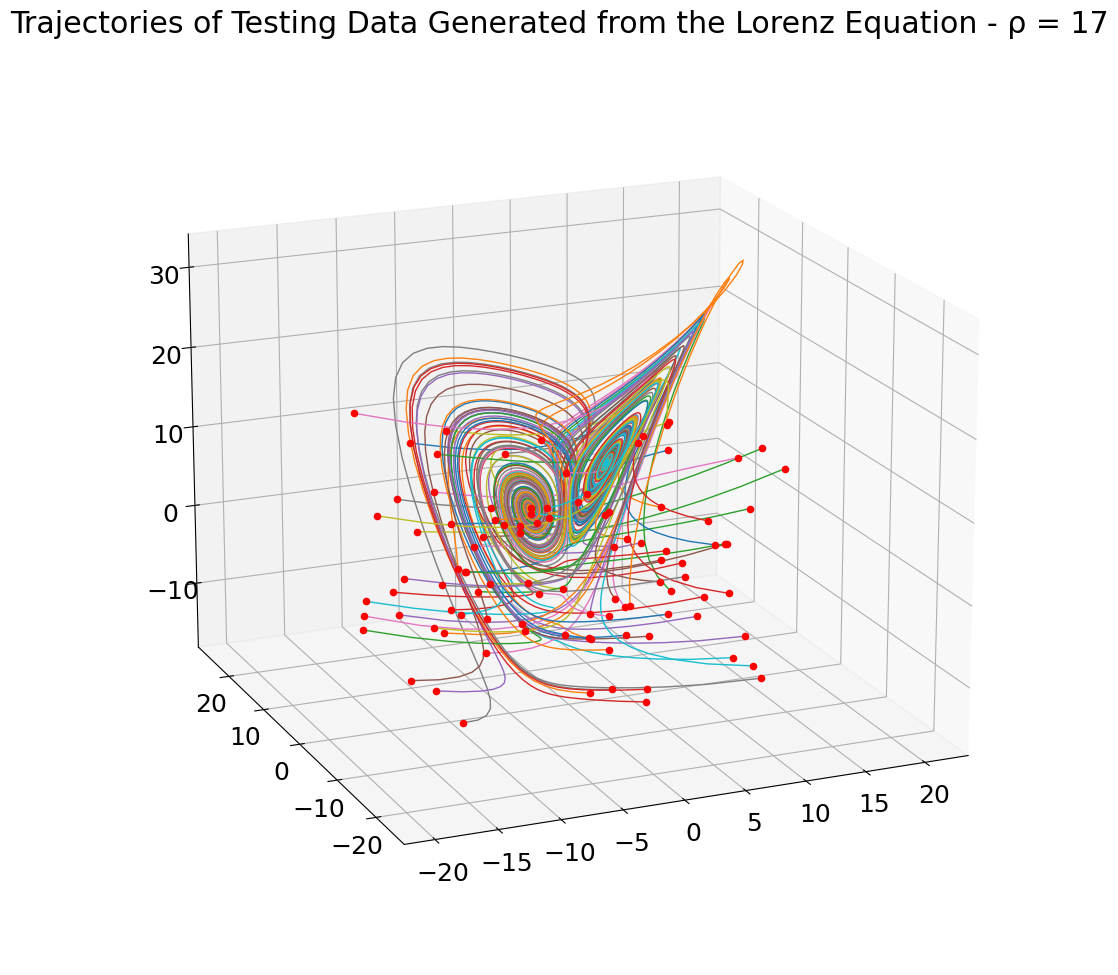

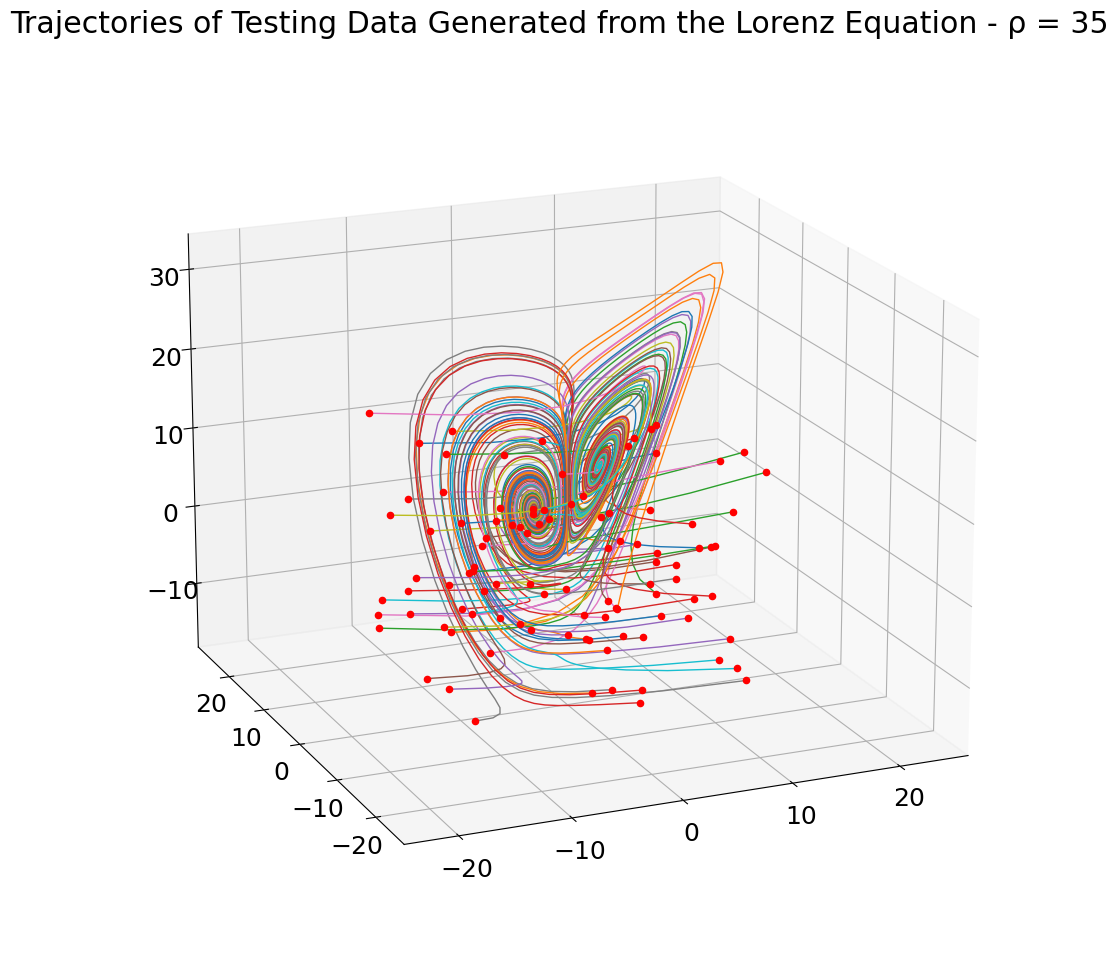

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy import integrate
from mpl_toolkits.mplot3d import Axes3D

dt = 0.01
T = 8
t = np.arange(0, T+dt, dt)
beta = 8/3
sigma = 10
rho_train = [10, 28, 40]
rho_test = [17, 35]

nn_input_train = np.zeros((100*(len(t)-1)*len(rho_train), 3))
nn_output_train = np.zeros_like(nn_input_train)
nn_input_test = np.zeros((100*(len(t)-1)*len(rho_test), 3))
nn_output_test = np.zeros_like(nn_input_test)

def lorenz_deriv(x_y_z, t, sigma=sigma, beta=beta, rho=rho_train[0]):
    x, y, z = x_y_z
    return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]

# Generate training data
np.random.seed(123)
x0_train = -15 + 30 * np.random.random((100, 3))

k = 0
for rho in rho_train:
    x_t = np.asarray([integrate.odeint(lorenz_deriv, x0_j, t, args=(rho,))
                      for x0_j in x0_train])
    for j in range(100):
        nn_input_train[k*(len(t)-1):(k+1)*(len(t)-1), :] = x_t[j, :-1, :]
        nn_output_train[k*(len(t)-1):(k+1)*(len(t)-1), :] = x_t[j, 1:, :]
        k += 1

# Generate testing data
np.random.seed(456)
x0_test = -15 + 30 * np.random.random((100, 3))

k = 0
for rho in rho_test:
    x_t = np.asarray([integrate.odeint(lorenz_deriv, x0_j, t, args=(rho,))
                      for x0_j in x0_test])
    for j in range(100):
        nn_input_test[k*(len(t)-1):(k+1)*(len(t)-1), :] = x_t[j, :-1, :]
        nn_output_test[k*(len(t)-1):(k+1)*(len(t)-1), :] = x_t[j, 1:, :]
        k += 1

rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = [12, 12]

# Plot the training data separately for each rho value
for j, rho_value in enumerate(rho_train):
    fig, ax = plt.subplots(1, 1, subplot_kw={'projection': '3d'})
    ax.set_title(f'Training Data generated by - ρ = {rho_value}')

    for k in range(100):
        index = j * 100 + k
        x, y, z = nn_input_train[index * (len(t) - 1):(index + 1) * (len(t) - 1), :].T
        ax.plot(x, y, z, linewidth=1)
        ax.scatter(x0_train[index % 100, 0], x0_train[index % 100, 1], x0_train[index % 100, 2], color='r')

    ax.view_init(18, -113)
    plt.show()

# Plot the testing data separately for each rho value
for j, rho_value in enumerate(rho_test):
    fig, ax = plt.subplots(1, 1, subplot_kw={'projection': '3d'})
    ax.set_title(f'Trajectories of Testing Data Generated from the Lorenz Equation - ρ = {rho_value}')

    for k in range(100):
        index = j * 100 + k
        x, y, z = nn_input_test[index * (len(t) - 1):(index + 1) * (len(t) - 1), :].T
        ax.plot(x, y, z, linewidth=1)
        ax.scatter(x0_test[index % 100, 0], x0_test[index % 100, 1], x0_test[index % 100, 2], color='r')

    ax.view_init(18, -113)
    plt.show()

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim


# Define activation functions
def logsig(x):
    return 1 / (1 + torch.exp(-x))

def radbas(x):
    return torch.exp(-torch.pow(x, 2))

def purelin(x):
    return x

# Define the model
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(in_features=3, out_features=10)
        self.fc2 = nn.Linear(in_features=10, out_features=10)
        self.fc3 = nn.Linear(in_features=10, out_features=3)
        
    def forward(self, x):
        x = logsig(self.fc1(x))
        x = radbas(self.fc2(x))
        x = purelin(self.fc3(x))
        return x


# Create model instance
model = MyModel()

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Train the model
for epoch in range(30):
    optimizer.zero_grad()
    outputs = model(nn_input_train)
    loss = criterion(outputs, nn_output_train)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}, loss={loss.item():.4f}")

Epoch 1, loss=44.9819
Epoch 2, loss=41.6365
Epoch 3, loss=36.0904
Epoch 4, loss=29.8251
Epoch 5, loss=24.2542
Epoch 6, loss=20.4077
Epoch 7, loss=18.7225
Epoch 8, loss=19.0162
Epoch 9, loss=20.5677
Epoch 10, loss=22.2543
Epoch 11, loss=22.7853
Epoch 12, loss=21.5125
Epoch 13, loss=19.7487
Epoch 14, loss=19.1264
Epoch 15, loss=19.4043
Epoch 16, loss=19.5348
Epoch 17, loss=19.1333
Epoch 18, loss=18.5313
Epoch 19, loss=18.0693
Epoch 20, loss=17.7909
Epoch 21, loss=17.6134
Epoch 22, loss=17.4422
Epoch 23, loss=17.2020
Epoch 24, loss=16.8493
Epoch 25, loss=16.3822
Epoch 26, loss=15.8334
Epoch 27, loss=15.2380
Epoch 28, loss=14.5992
Epoch 29, loss=13.8930
Epoch 30, loss=13.1083


In [34]:
# Test the model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    test_outputs = model(nn_input_test)
    test_loss = criterion(test_outputs, nn_output_test)
    print(f"Test loss: {test_loss.item():.4f}")


Test loss: 12.6236


Run 1
Run 2
Run 3
Run 4
Run 5
Run 6
Run 7
Run 8
Run 9
Run 10


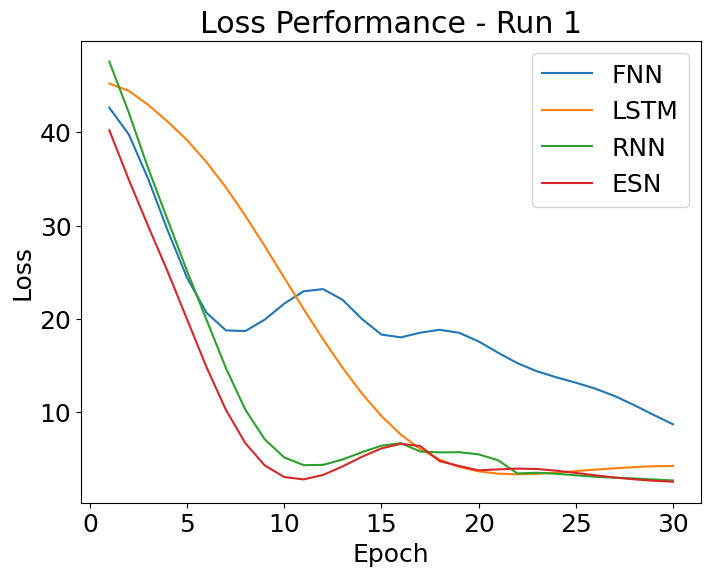

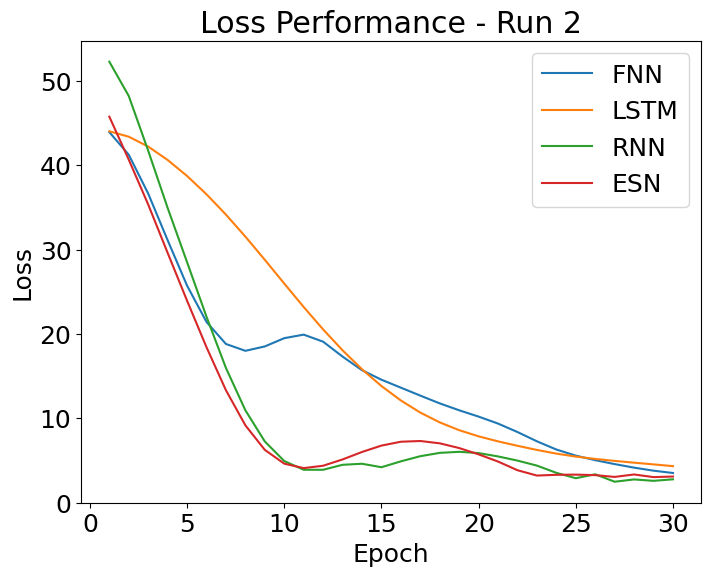

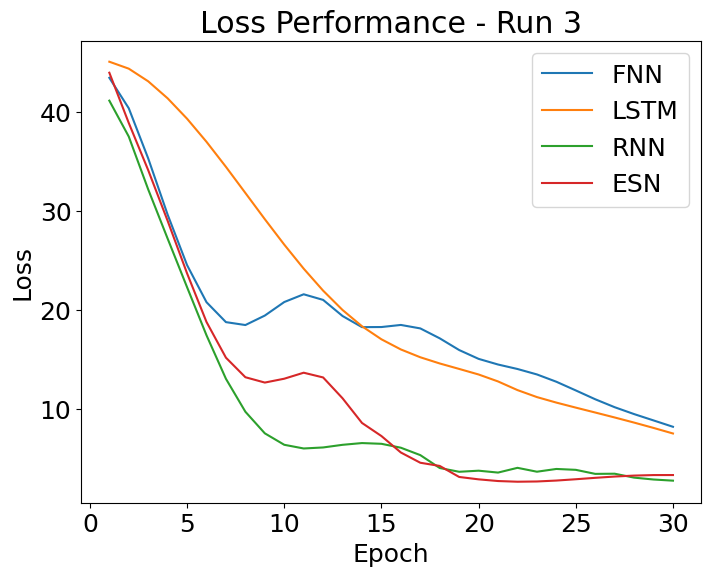

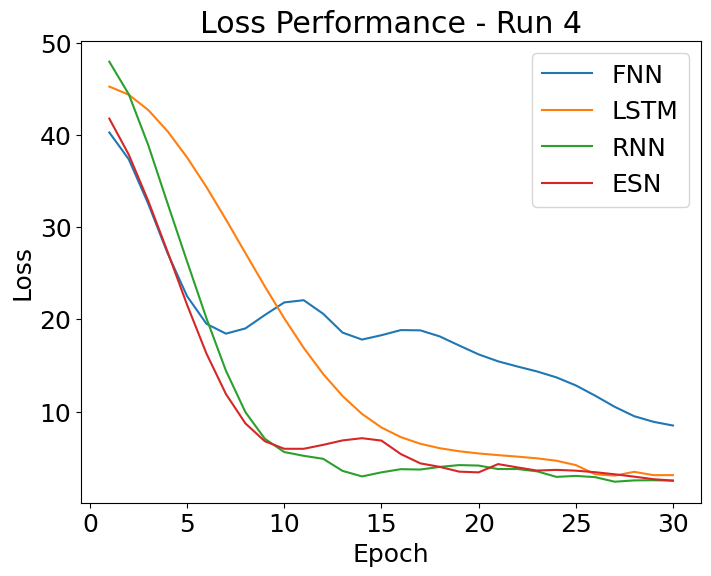

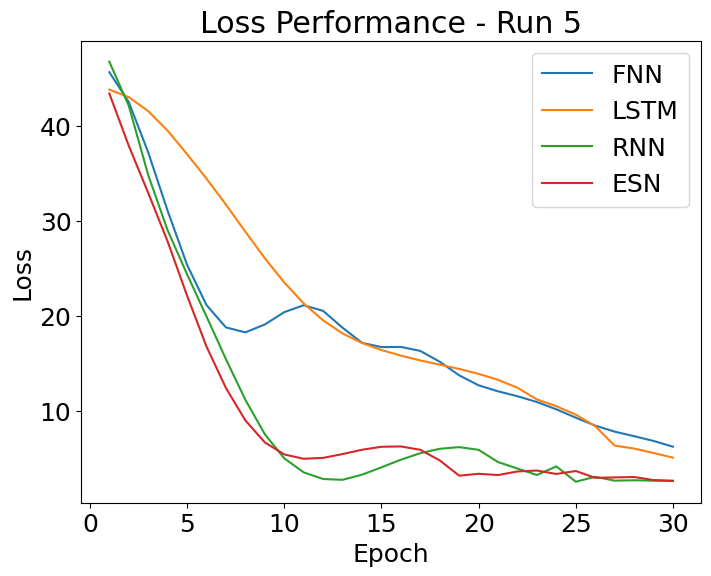

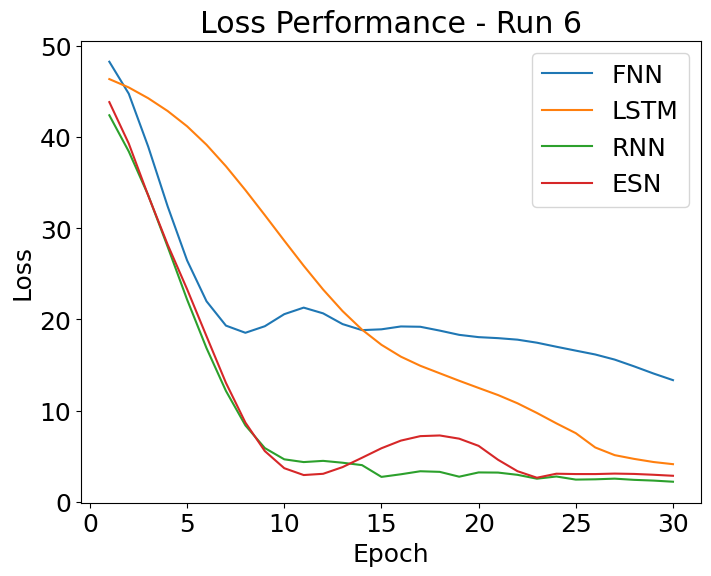

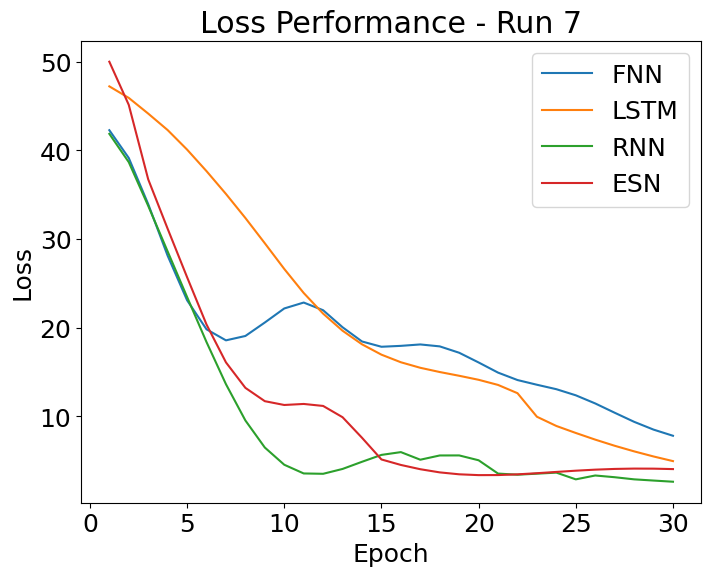

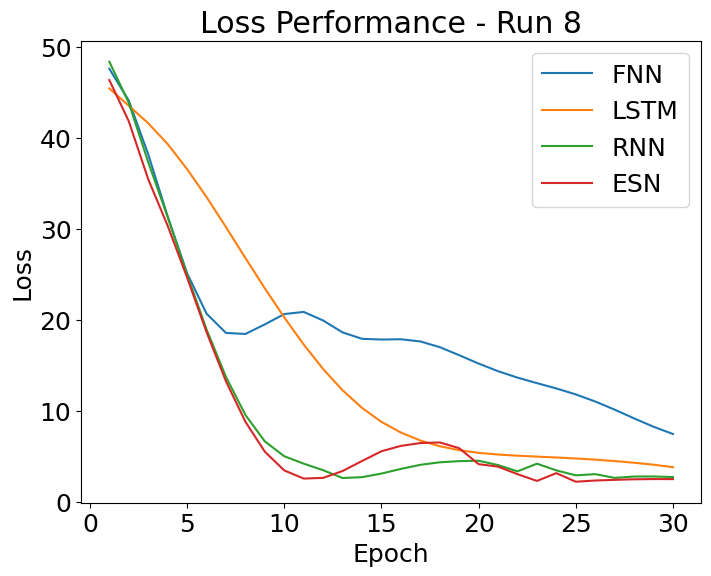

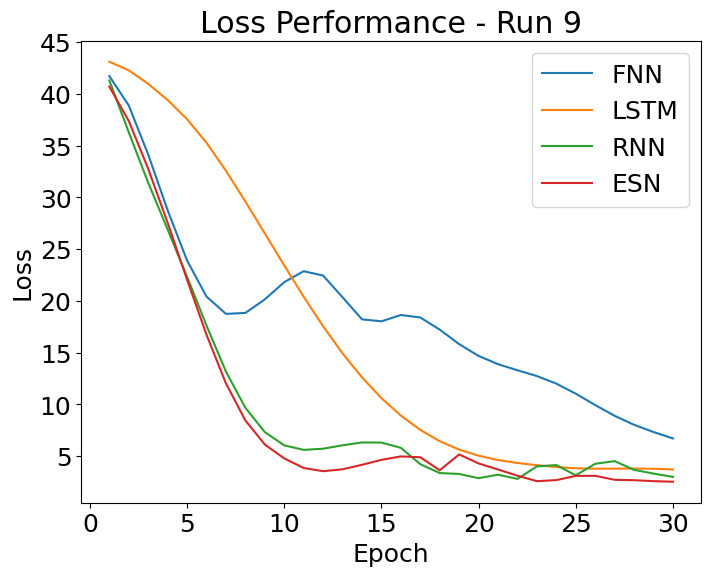

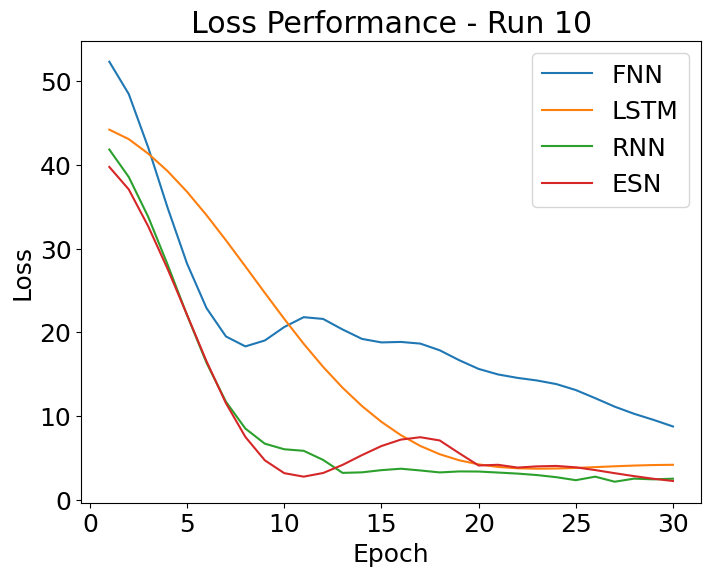

FNN - Average Loss: 8.765507
LSTM - Average Loss: 4.187810
RNN - Average Loss: 2.530063
ESN - Average Loss: 2.258718
FNN - Variability of Loss: 0.000000
LSTM - Variability of Loss: 0.000000
RNN - Variability of Loss: 0.000000
ESN - Variability of Loss: 0.000000
Average Testing Losses:
FNN: 7.527435636520385
LSTM: 4.497796869277954
RNN: 2.825124502182007
ESN: 3.1099908113479615


In [35]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define activation functions
def logsig(x):
    return 1 / (1 + torch.exp(-x))

def radbas(x):
    return torch.exp(-torch.pow(x, 2))

def purelin(x):
    return x

# Define the feed-forward neural network (FNN) model
class FNN(nn.Module):
    def __init__(self):
        super(FNN, self).__init__()
        self.fc1 = nn.Linear(in_features=3, out_features=10)
        self.fc2 = nn.Linear(in_features=10, out_features=10)
        self.fc3 = nn.Linear(in_features=10, out_features=3)
        
    def forward(self, x):
        x = logsig(self.fc1(x))
        x = radbas(self.fc2(x))
        x = purelin(self.fc3(x))
        return x

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=3, hidden_size=10, num_layers=1, batch_first=True)
        self.fc = nn.Linear(in_features=10, out_features=3)
        
    def forward(self, x):
        x, _ = self.lstm(x)
        x = purelin(self.fc(x[:, -1, :]))
        return x

# Define the RNN model
class RNNModel(nn.Module):
    def __init__(self):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size=3, hidden_size=10, num_layers=1, batch_first=True)
        self.fc = nn.Linear(in_features=10, out_features=3)
        
    def forward(self, x):
        x, _ = self.rnn(x)
        x = purelin(self.fc(x[:, -1, :]))
        return x

# Define the Echo State Network (ESN) model
class ESNModel(nn.Module):
    def __init__(self):
        super(ESNModel, self).__init__()
        self.esn = nn.RNN(input_size=3, hidden_size=10, num_layers=1, batch_first=True)
        self.fc = nn.Linear(in_features=10, out_features=3)
        
    def forward(self, x):
        x, _ = self.esn(x)
        x = purelin(self.fc(x[:, -1, :]))
        return x

# Create instances of the models
fnn_model = FNN()
lstm_model = LSTMModel()
rnn_model = RNNModel()
esn_model = ESNModel()

# Define loss functions and optimizers for each model
criterion = nn.MSELoss()
fnn_optimizer = optim.SGD(fnn_model.parameters(), lr=0.01, momentum=0.9)
lstm_optimizer = optim.SGD(lstm_model.parameters(), lr=0.01, momentum=0.9)
rnn_optimizer = optim.SGD(rnn_model.parameters(), lr=0.01, momentum=0.9)
esn_optimizer = optim.SGD(esn_model.parameters(), lr=0.01, momentum=0.9)


# Set the number of runs
num_runs = 10

# Define arrays to store the average testing losses for each run
fnn_avg_test_losses = []
lstm_avg_test_losses = []
rnn_avg_test_losses = []
esn_avg_test_losses = []

# Perform multiple runs
for run in range(num_runs):
    print(f"Run {run+1}")

    # Reset the models and optimizers for each run
    fnn_model = FNN()
    lstm_model = LSTMModel()
    rnn_model = RNNModel()
    esn_model = ESNModel()

    fnn_optimizer = optim.SGD(fnn_model.parameters(), lr=0.01, momentum=0.9)
    lstm_optimizer = optim.SGD(lstm_model.parameters(), lr=0.01, momentum=0.9)
    rnn_optimizer = optim.SGD(rnn_model.parameters(), lr=0.01, momentum=0.9)
    esn_optimizer = optim.SGD(esn_model.parameters(), lr=0.01, momentum=0.9)

    # Define lists to store the losses for each epoch
    fnn_epoch_losses = []
    lstm_epoch_losses = []
    rnn_epoch_losses = []
    esn_epoch_losses = []

    # Define lists to store the final loss for each run
    fnn_final_losses = []
    lstm_final_losses = []
    rnn_final_losses = []
    esn_final_losses = []

    # Train the models
    for epoch in range(30):
        # Train the feed-forward neural network (FNN)
        fnn_optimizer.zero_grad()
        fnn_outputs = fnn_model(nn_input_train)
        fnn_loss = criterion(fnn_outputs, nn_output_train)
        fnn_loss.backward()
        fnn_optimizer.step()

        # Train the LSTM model
        lstm_optimizer.zero_grad()
        lstm_outputs = lstm_model(nn_input_train.unsqueeze(1))
        lstm_loss = criterion(lstm_outputs, nn_output_train)
        lstm_loss.backward()
        lstm_optimizer.step()

        # Train the RNN model
        rnn_optimizer.zero_grad()
        rnn_outputs = rnn_model(nn_input_train.unsqueeze(1))
        rnn_loss = criterion(rnn_outputs, nn_output_train)
        rnn_loss.backward()
        rnn_optimizer.step()

        # Train the Echo State Network (ESN) model
        esn_optimizer.zero_grad()
        esn_outputs = esn_model(nn_input_train.unsqueeze(1))
        esn_loss = criterion(esn_outputs, nn_output_train)
        esn_loss.backward()
        esn_optimizer.step()

        # Store the losses for each epoch
        fnn_epoch_losses.append(fnn_loss.item())
        lstm_epoch_losses.append(lstm_loss.item())
        rnn_epoch_losses.append(rnn_loss.item())
        esn_epoch_losses.append(esn_loss.item())

    # Store the final loss for each run
    fnn_final_losses.append(fnn_loss.item())
    lstm_final_losses.append(lstm_loss.item())
    rnn_final_losses.append(rnn_loss.item())
    esn_final_losses.append(esn_loss.item())
    
    # Plot the loss performance for each run
    epochs = range(1, 31)
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, fnn_epoch_losses, label="FNN")
    plt.plot(epochs, lstm_epoch_losses, label="LSTM")
    plt.plot(epochs, rnn_epoch_losses, label="RNN")
    plt.plot(epochs, esn_epoch_losses, label="ESN")

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Loss Performance - Run {run+1}')
    plt.legend()

    # Calculate the testing losses for each model
    fnn_test_outputs = fnn_model(nn_input_test)
    fnn_test_loss = criterion(fnn_test_outputs, nn_output_test)

    lstm_test_outputs = lstm_model(nn_input_test.unsqueeze(1))
    lstm_test_loss = criterion(lstm_test_outputs, nn_output_test)

    rnn_test_outputs = rnn_model(nn_input_test.unsqueeze(1))
    rnn_test_loss = criterion(rnn_test_outputs, nn_output_test)

    esn_test_outputs = esn_model(nn_input_test.unsqueeze(1))
    esn_test_loss = criterion(esn_test_outputs, nn_output_test)

    # Store the testing losses for each run
    fnn_avg_test_losses.append(fnn_test_loss.item())
    lstm_avg_test_losses.append(lstm_test_loss.item())
    rnn_avg_test_losses.append(rnn_test_loss.item())
    esn_avg_test_losses.append(esn_test_loss.item())

# Calculate the average testing
plt.show()

# Calculate the average and variability of the losses using the final loss for each run
fnn_avg_loss = np.mean(fnn_final_losses)
fnn_var_loss = np.var(fnn_final_losses)
lstm_avg_loss = np.mean(lstm_final_losses)
lstm_var_loss = np.var(lstm_final_losses)
rnn_avg_loss = np.mean(rnn_final_losses)
rnn_var_loss = np.var(rnn_final_losses)
esn_avg_loss = np.mean(esn_final_losses)
esn_var_loss = np.var(esn_final_losses)

# Print the average and variability of the losses with a maximum of 6 decimal places
print("FNN - Average Loss: {:.6f}".format(fnn_avg_loss))
print("LSTM - Average Loss: {:.6f}".format(lstm_avg_loss))
print("RNN - Average Loss: {:.6f}".format(rnn_avg_loss))
print("ESN - Average Loss: {:.6f}".format(esn_avg_loss))
print("FNN - Variability of Loss: {:.6f}".format(fnn_var_loss))
print("LSTM - Variability of Loss: {:.6f}".format(lstm_var_loss))
print("RNN - Variability of Loss: {:.6f}".format(rnn_var_loss))
print("ESN - Variability of Loss: {:.6f}".format(esn_var_loss))

# Calculate the average testing losses for each model
fnn_avg_test_loss = sum(fnn_avg_test_losses) / num_runs
lstm_avg_test_loss = sum(lstm_avg_test_losses) / num_runs
rnn_avg_test_loss = sum(rnn_avg_test_losses) / num_runs
esn_avg_test_loss = sum(esn_avg_test_losses) / num_runs

# Print the average testing losses for each model
print("Average Testing Losses:")
print("FNN:", fnn_avg_test_loss)
print("LSTM:", lstm_avg_test_loss)
print("RNN:", rnn_avg_test_loss)
print("ESN:", esn_avg_test_loss)

